# Проект: Обучение с учителем: качество модели
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install phik -q
!pip install shap -q
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import shap
import warnings

### Шаг 1. Загрузка данных

In [2]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [3]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Шаг 2. Предобработка данных

In [7]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [9]:
market_file.duplicated().sum()

0

In [10]:
for col in market_file.select_dtypes(exclude='number').columns.tolist():
    print(f'{col} : {market_file[col].unique()}')
    print()

Покупательская активность : ['Снизилась' 'Прежний уровень']

Тип сервиса : ['премиум' 'стандартт' 'стандарт']

Разрешить сообщать : ['да' 'нет']

Популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



In [11]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')

In [12]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [13]:
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксесcуары')

In [14]:
market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесcуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [15]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [16]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [17]:
market_money.duplicated().sum()

0

In [18]:
for col in market_money.select_dtypes(exclude='number').columns.tolist():
    print(f'{col} : {market_money[col].unique()}')
    print()

Период : ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']



In [19]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [20]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [21]:
market_time.duplicated().sum()

0

In [22]:
for col in market_time.select_dtypes(exclude='number').columns.tolist():
    print(f'{col} : {market_time[col].unique()}')
    print()

Период : ['текущий_месяц' 'предыдцщий_месяц']



In [23]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [24]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [25]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [26]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [27]:
money.duplicated().sum()

0

Вывод:
- Посмотрели типы данных везде верные
- Посмотрели явные дубликаты нигде не обнаружены
- Устранили неявный дубликат в "Тип сервиса"-стандартт и поправили две ошибки в написании "Период"-предыдцщий_месяц и "Популярная_категория"-Косметика и аксесуары

### Шаг 3. Исследовательский анализ данных

In [28]:
#уберем клиентов с нулевой покупательской активностью за последние 3 месяца
clients_zero = market_money[market_money['Выручка'] == 0]['id'].unique()

In [29]:
clients_zero

array([215348, 215357, 215359])

In [30]:
money = money[~money['id'].isin(clients_zero)]
market_money = market_money.loc[~market_money['id'].isin(clients_zero), :]
market_file = market_file.loc[~market_file['id'].isin(clients_zero), :]
market_time = market_time.loc[~market_time['id'].isin(clients_zero), :]

In [31]:
market_money.info()
market_file.info()
market_time.info()
money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   

In [32]:
cats = list(market_file.select_dtypes(include=['object']).columns)
nums = list(market_file.select_dtypes(exclude=['object']).columns)

In [33]:
nums

['id',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

In [34]:
cats

['Покупательская активность',
 'Тип сервиса',
 'Разрешить сообщать',
 'Популярная_категория']

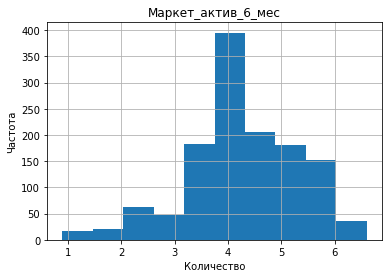

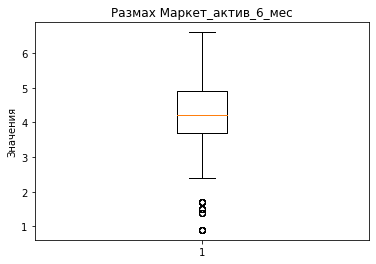



Статистика


count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

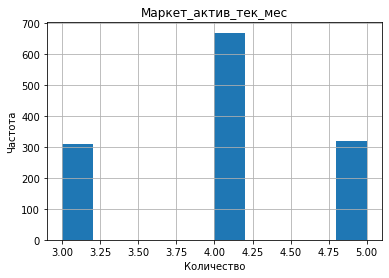

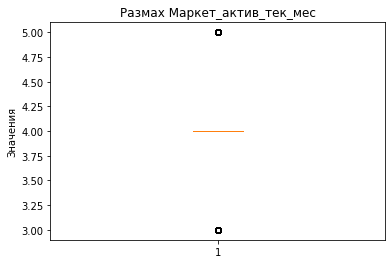



Статистика


count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64

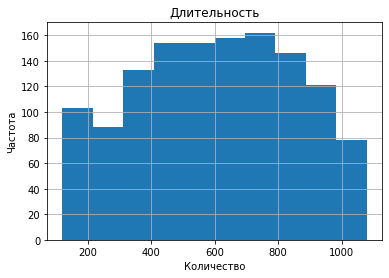

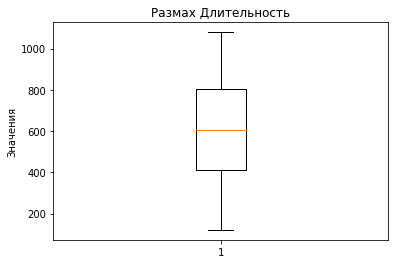



Статистика


count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

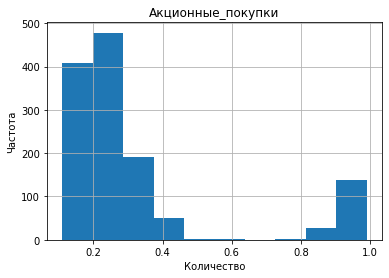

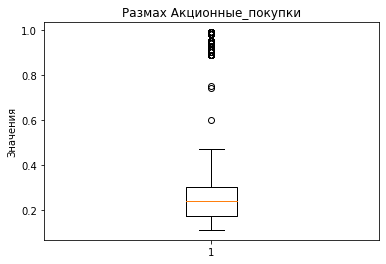



Статистика


count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

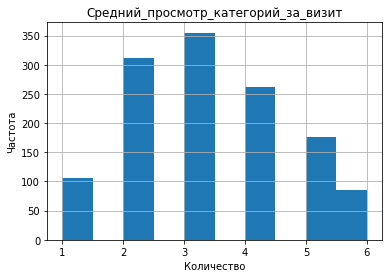

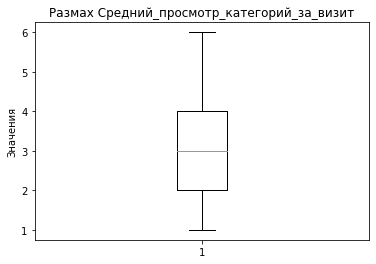



Статистика


count    1297.000000
mean        3.267540
std         1.354623
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

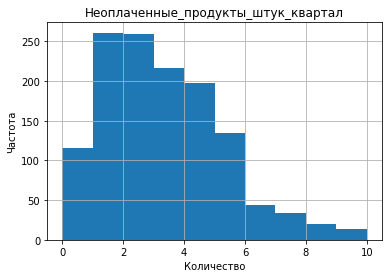

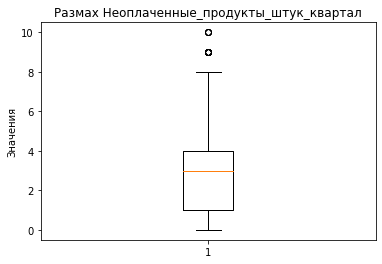



Статистика


count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

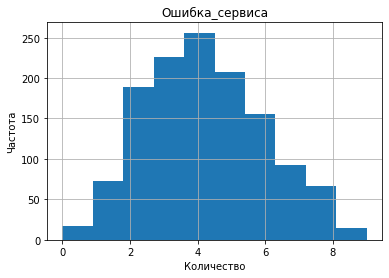

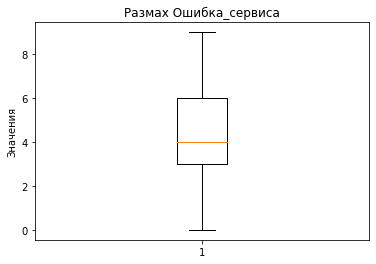



Статистика


count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

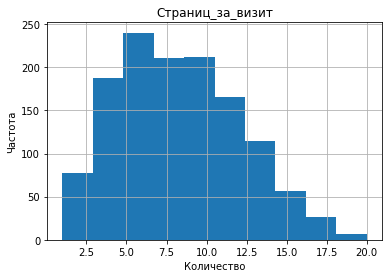

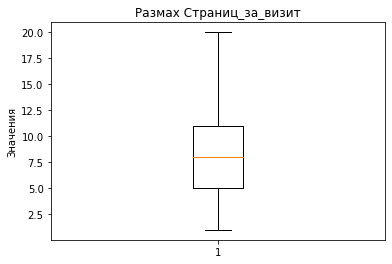



Статистика


count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

In [35]:
for col in nums:
    if col != 'id':
        market_file[col].hist(bins=10);
        plt.title(col)
        plt.xlabel('Количество')
        plt.ylabel('Частота')
        plt.show()
        print('\n')
        plt.boxplot(market_file[col]);
        plt.title(f'Размах {col}')
        plt.ylabel('Значения')
        plt.show()
        print('\n')
        print('Статистика')
        display(market_file[col].describe())
        print('\n')

- Посмотрели все численные столбцы таблицы market_file:
 - Маркет_актив_6_мес в среднем 4 в месяц проходят активности маркетинга
 - Длительность большинство клиентов зарегистрированы на сайте чуть больше полутора лет 602 дня
 - Акционные_покупки составляет 0.2, есть выбросы кто то совершает небольшое по частоте(более 100раз) 0.9 возможно люди которые специально отслеживают акции и покупают только в них
 - Средний_просмотр_категорий_за_визит в среднем 3 категории смотрят пользователи за висит
 - Неоплаченные_продукты_штук_квартал за последние три месяца неоплаченные товары примерно 2-3 штуки в большинстве раз
 - Ошибка_сервиса число сбоев в среднем 4
 - Страниц_за_визит примерно 8 страниц в большинстве раз смотрят пользователи

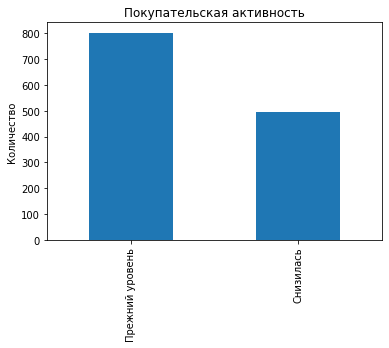

Прежний уровень    802
Снизилась          495
Name: Покупательская активность, dtype: int64

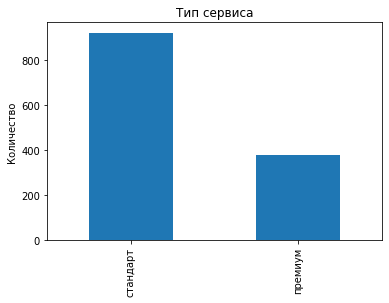

стандарт    922
премиум     375
Name: Тип сервиса, dtype: int64

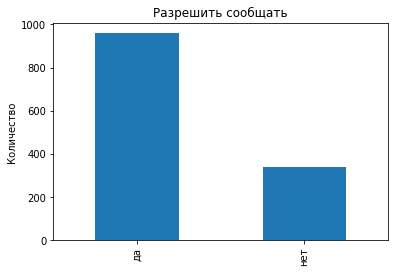

да     959
нет    338
Name: Разрешить сообщать, dtype: int64

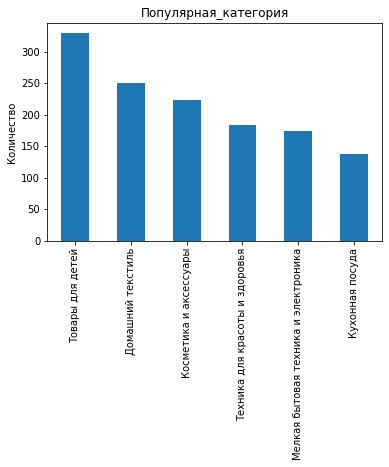

Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесcуары                  223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [36]:
for col in cats:
    market_file[col].value_counts().plot(kind='bar', figsize=(6, 4));
    plt.title(col)
    plt.ylabel('Количество')
    plt.show()
    print('\n')
    display(market_file[col].value_counts())
    print('\n')

- Посмотрели все категориальные столбцы таблицы market_file:
 - Покупательская активность осталась на прежнем уровне почти в половину раз больше
 - Тип сервиса в три раза больше стандарт чем премиум
 - Разрешают сообщить в три раза больше чем нет
 - Популярная категория лидеры это товары для детей и домашний текстиль, самая низкая популярность у кухонной посуды

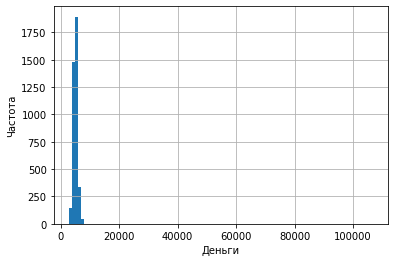

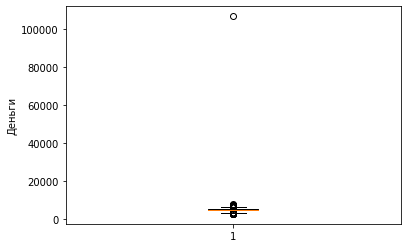

текущий_месяц          1297
препредыдущий_месяц    1297
предыдущий_месяц       1297
Name: Период, dtype: int64

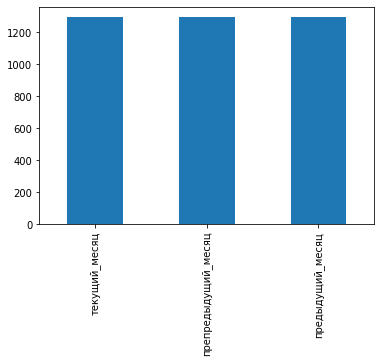

In [37]:
market_money['Выручка'].hist(bins=100);
plt.ylabel('Частота')
plt.xlabel('Деньги')
plt.show()
plt.boxplot(market_money['Выручка'])
plt.ylabel('Деньги')
plt.show()
market_money['Период'].value_counts().plot(kind='bar');
market_money['Период'].value_counts()

In [38]:
market_money[market_money['Выручка'] > 10000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [39]:
market_money = market_money[market_money['Выручка'] < 10000]

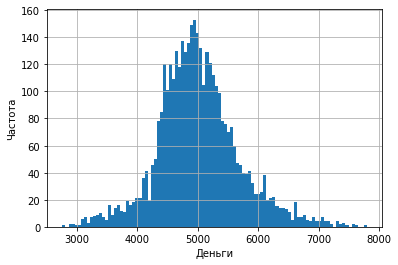

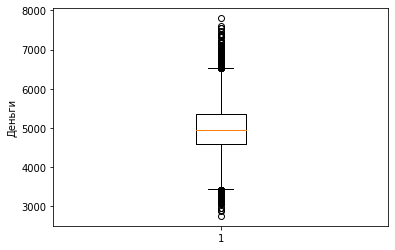

,Выручка
count,3890.000000
mean,5007.541902
std,679.235737
min,2758.700000
25%,4592.000000
50%,4959.000000
75%,5363.000000
max,7799.400000


In [40]:
market_money['Выручка'].hist(bins=100);
plt.ylabel('Частота')
plt.xlabel('Деньги')
plt.show()
plt.boxplot(market_money['Выручка'])
plt.ylabel('Деньги')
plt.show()
market_money.drop('id', axis=1).describe()

- получается что в периодах есть равное количество данных о выручках
- убрали выброс в выручку 106862.2 он был там один и очень отличался от всех
- выручка в среднем 5007 в большинстве раз

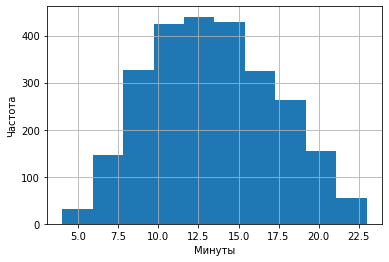

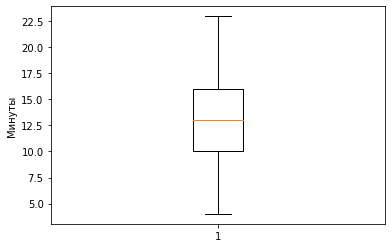

,минут
count,2594.000000
mean,13.340401
std,4.081999
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


In [41]:
market_time['минут'].hist(bins=10);
plt.ylabel('Частота')
plt.xlabel('Минуты')
plt.show()
plt.boxplot(market_time['минут'])
plt.ylabel('Минуты')
plt.show()
market_time.drop('id', axis=1).describe()

текущий_месяц       1297
предыдущий_месяц    1297
Name: Период, dtype: int64

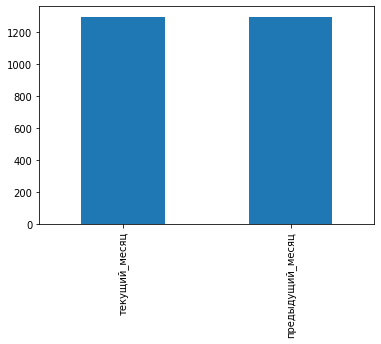

In [42]:
market_time['Период'].value_counts().plot(kind='bar');
market_time['Период'].value_counts()

- в среднем 13 минут проведено на сайте

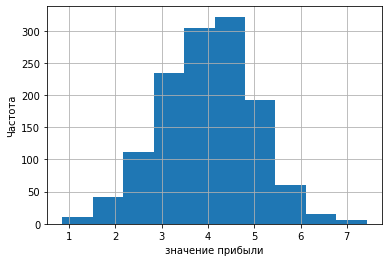

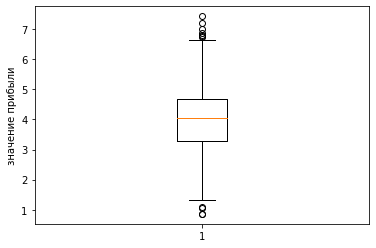

,Прибыль
count,1297.000000
mean,3.997610
std,1.010813
min,0.860000
25%,3.300000
50%,4.040000
75%,4.670000
max,7.430000


In [44]:
money['Прибыль'].hist(bins=10);
plt.ylabel('Частота')
plt.xlabel('значение прибыли')
plt.show()
plt.boxplot(money['Прибыль'])
plt.ylabel('значение прибыли')
plt.show()
money.drop('id', axis=1).describe()

- Значение прибыли в среднем 3.3

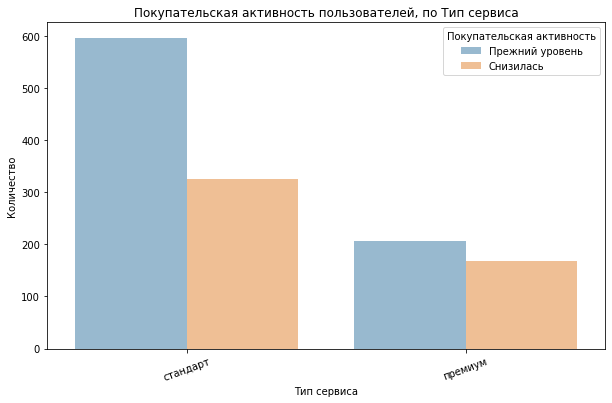

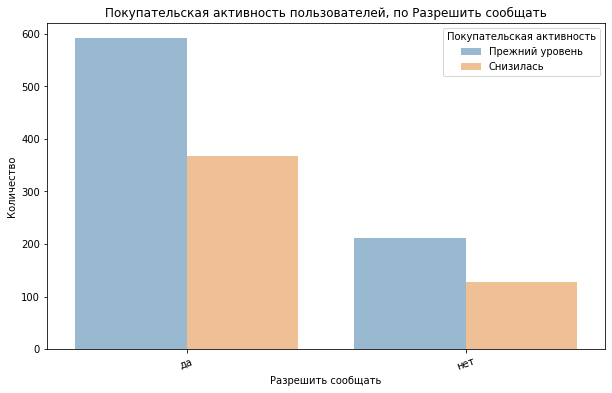

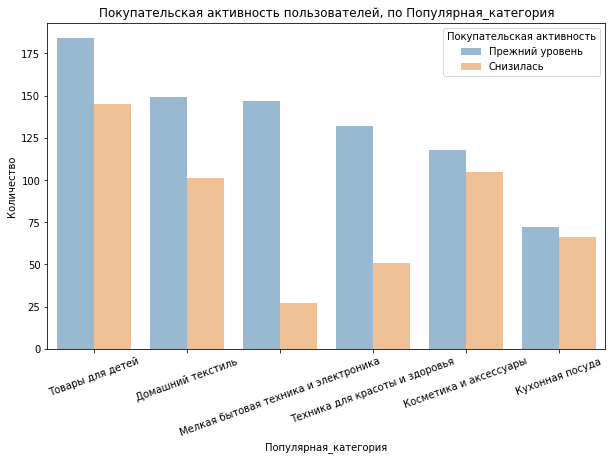

In [65]:
for col in cats:
    if col != 'id' and col != 'Покупательская активность':
        data = market_file[['Покупательская активность', col]].value_counts().reset_index()
        data = pd.DataFrame(data)
        data.columns = ['Покупательская активность', col, 'count']
        plt.figure(figsize = (10, 6)) 
        fig = sns.barplot(
            alpha = 0.5,
            x = col, 
            y = 'count',
            hue = 'Покупательская активность',
            data = data
          )
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.title (f'Покупательская активность пользователей, по {col}')
        fig.set_xticklabels(fig.get_xticklabels(), rotation=20)
        plt.show()

#### Общий вывод по шагу:
* market_file
 - Посмотрели все категориальные столбцы таблицы market_file:
   - Покупательская активность осталась на прежнем уровне почти в половину раз больше
   - Тип сервиса в три раза больше стандарт чем премиум
   - Разрешают сообщить в три раза больше чем нет
   - Популярная категория лидеры это товары для детей и домашний текстиль, самая низкая популярность у кухонной посуды
 - Посмотрели все численные столбцы таблицы market_file:
   - Маркет_актив_6_мес в среднем 4 в месяц проходят активности маркетинга
   - Длительность большинство клиентов зарегистрированы на сайте чуть больше полутора лет 602 дня
   - Акционные_покупки составляет 0.2, есть выбросы кто то совершает небольшое по частоте(более 100раз) 0.9 возможно люди которые специально отслеживают акции и покупают только в них
   - Средний_просмотр_категорий_за_визит в среднем 3 категории смотрят пользователи за висит
   - Неоплаченные_продукты_штук_квартал за последние три месяца неоплаченные товары примерно 2-3 штуки в большинстве раз
   - Ошибка_сервиса число сбоев в среднем 4
   - Страниц_за_визит примерно 8 страниц в большинстве раз смотрят пользователи
* market_money
 - в периодах есть равное количество данных о выручках
 - убрали выброс в выручку 106862.2 он был там один и очень отличался от всех
 - выручка в среднем 5007 в большинстве раз
* market_time
 - в среднем 13 минут проведено на сайте
* money
 - Значение прибыли в среднем 3.3
* Дополнительно посмотрели на распределение категориальных признаков для обеих групп снизилась и нет покупательская активность
 - По типу сервиса можно сказать что снизилась больше у стандарт, у премиум меньше
 - По категориям сильно снизилась активность в категориях мелкая БТ и электроника и Техника для красоты и здоровья

### Шаг 4. Объединение таблиц

In [66]:
market_money_tr = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum').reset_index()
market_money_tr.columns.name = None
market_money_tr.shape

(1297, 4)

In [67]:
market_money_tr.head()

,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [68]:
market_money_tr.columns = ['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_tr.head()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [69]:
market_time_tr = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='sum').reset_index()
market_time_tr.columns.name = None
market_time_tr.shape

(1297, 3)

In [70]:
market_time_tr.head()

,id,предыдущий_месяц,текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [71]:
market_time_tr.columns = ['id', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_tr.head()

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


In [77]:
data_market = market_file.merge(market_money_tr, how='inner', on='id')\
    .merge(market_time_tr, how='inner', on='id')

In [78]:
data_market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [79]:
data_market.shape

(1297, 18)

In [80]:
data_market.query('выручка_предыдущий_месяц == 0 and выручка_препредыдущий_месяц == 0 and выручка_текущий_месяц == 0')

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц


In [83]:
data_market.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [82]:
data_market = data_market.dropna()

* Объединили таблицы market_file.csv, market_money.csv, market_time.csv.
* Данные о выручке и времени на сайте находились в одном столбце для всех периодов. В итоговой таблице сделали отдельный столбец для каждого периода.
* Проверили что в таблице нет данных о клиентах с выручкой 0 хотя бы в одном периоде

### Шаг 5.  Корреляционный анализ

In [84]:
data_market = data_market.drop(['id'], axis=1)

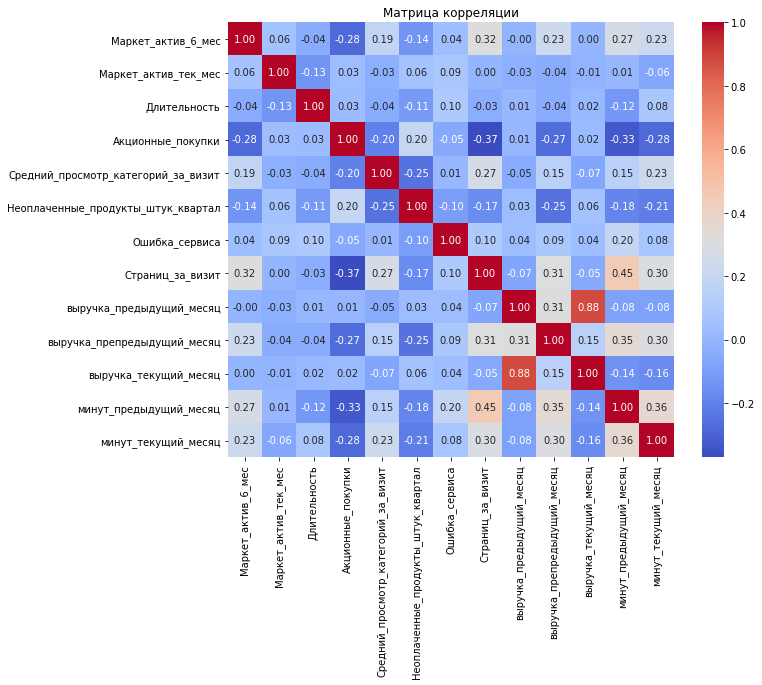

In [85]:
plt.figure(figsize=(10, 8));
sns.heatmap(data_market[data_market.select_dtypes(exclude='object').columns.to_list()].corr(method='spearman'), cmap='coolwarm', fmt='.2f', annot=True)
plt.title('Матрица корреляции')
plt.show()

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


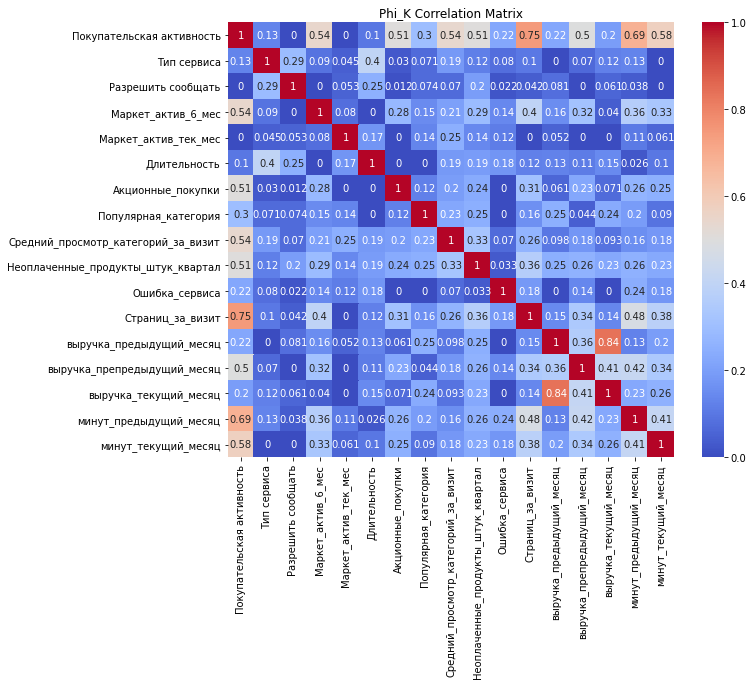

In [86]:
corr_matrix = data_market.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Посмотрели матрицы корреляции, мультиколлинеарности не обнаружено.Неплохая корреляция с покупательской активностью у страниц за визит, выручки, минут.

### Шаг 6. Использование пайплайнов

In [87]:
data_market.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [88]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

ohe_columns = ['Популярная_категория',
               'Разрешить сообщать'
               ]
ord_columns = ['Тип сервиса']

In [89]:
num_columns = data_market.select_dtypes(exclude='object').columns.to_list()

In [90]:
num_columns

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

In [63]:
# num_columns = ['Страниц_за_визит']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(
        [
            'Покупательская активность'
        ], 
        axis=1
    ),
    data_market['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_market['Покупательская активность']
)

In [92]:
X_train.shape, X_test.shape

((972, 16), (324, 16))

In [93]:
y_train.value_counts()

Прежний уровень    601
Снизилась          371
Name: Покупательская активность, dtype: int64

In [99]:
l_encoder = LabelEncoder()
y_train = l_encoder.fit_transform(y_train)
y_test = l_encoder.transform(y_test)
list(l_encoder.classes_)

[0, 1]

In [100]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

In [101]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
         handle_unknown='error'
                #handle_unknown = 'use_encoded_value',
                #unknown_value = np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [102]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [103]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [104]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели SVC()
{
        'models': [SVC(random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Метрику выбираем roc-auc так как у нас данных одного класса больше чем другого, но дисбаланс в целом не сильно большой поэтому подошли бы и другие метрики

In [107]:
warnings.filterwarnings('ignore')
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
#y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

Выстроили полный пайплайн для обучения модели, использовали ordianal encoder-для ранговых значений и one hot encoder-для бинарных значений.Как бы не казалось что популярная категория должна была бы быть в ordianal encoder, но популярная категория это номинальная переменная, а ранговый столбец у нас тип сервиса так как мы можем сравнить лучше или хуже.
Метрику выбрали roc-auc так как у нас несбалансированный класс.
По итогу лучшая модель получилась KNeighborsClassifier(n_neighbors=15) ROC-AUC 0.91 

### Шаг 7. Анализ важности признаков

In [108]:
best_model = randomized_search.best_estimator_.named_steps['models']

In [109]:
best_model

KNeighborsClassifier(n_neighbors=15)

In [110]:
X_train_2 = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_2 = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [111]:
all_cols = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names().tolist() + num_columns + ord_columns

In [112]:
all_cols

['x0_Косметика и аксесcуары',
 'x0_Кухонная посуда',
 'x0_Мелкая бытовая техника и электроника',
 'x0_Техника для красоты и здоровья',
 'x0_Товары для детей',
 'x1_нет',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц',
 'Тип сервиса']

In [113]:
X_train_p = pd.DataFrame(
    X_train_2,
    columns=all_cols
)

X_test_p = pd.DataFrame(
    X_test_2,
    columns=all_cols   
)

In [114]:
shap_samples = shap.sample(X_train_p, 50)

In [115]:
explainer = shap.KernelExplainer(best_model.predict_proba, shap_samples)

In [116]:
shap_values = explainer.shap_values(shap_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

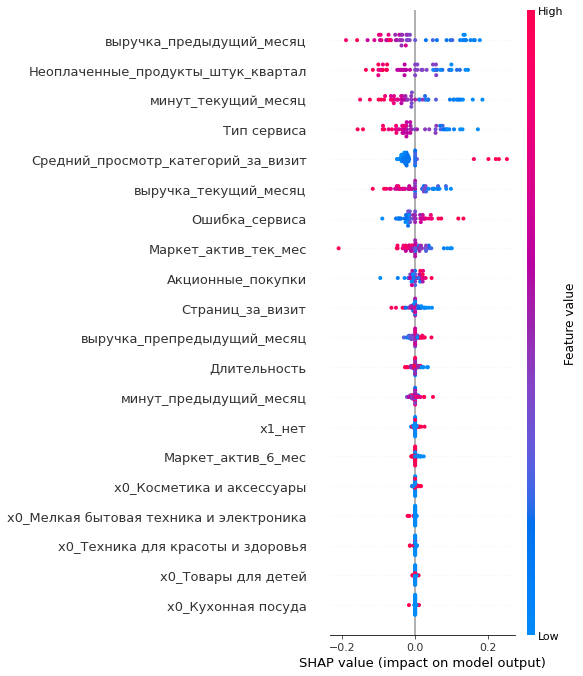

In [117]:
shap.summary_plot(shap_values[:,:,1], shap_samples)

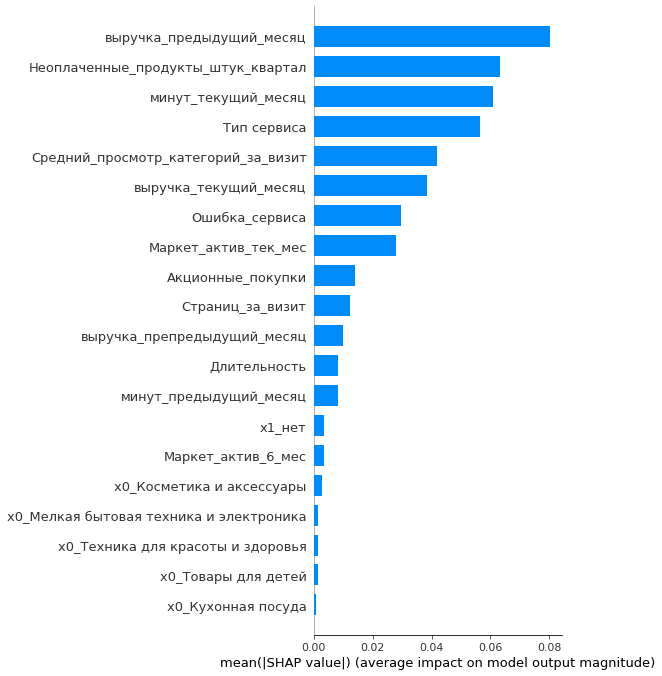

In [118]:
shap.summary_plot(shap_values[:,:,1], shap_samples, plot_type='bar')

* посмотрели на распределение важности признаков для модели, 
- Наиболее важными модель выделяет сильнее всех признак выручка за предыдущий месяц, неоплаченные продукты, минут текущий месяц, тип сервиса.
* Наиболее неважными считает минут предыдущий месяц, длительность, выручка препредыдущий месяц

### Шаг 8. Сегментация покупателей

Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

In [119]:
data_market.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [120]:
predicted = randomized_search.predict_proba(X_test)[:, 1]

In [121]:
predicted.shape

(324,)

In [122]:
X_test['Покупательская активность'] = predicted

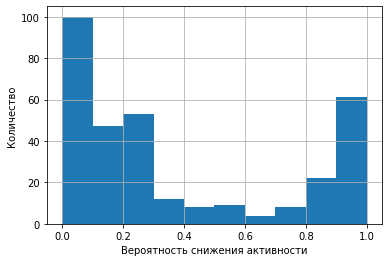

In [123]:
X_test['Покупательская активность'].hist(bins=10);
plt.ylabel('Количество')
plt.xlabel('Вероятность снижения активности')
plt.show()

In [124]:
segment = X_test[X_test['Покупательская активность'] >= 0.6]

In [125]:
segment1 = segment[segment['Акционные_покупки'] > 0.6]

In [126]:
segment.shape

(101, 17)

In [127]:
segment1.shape

(38, 17)

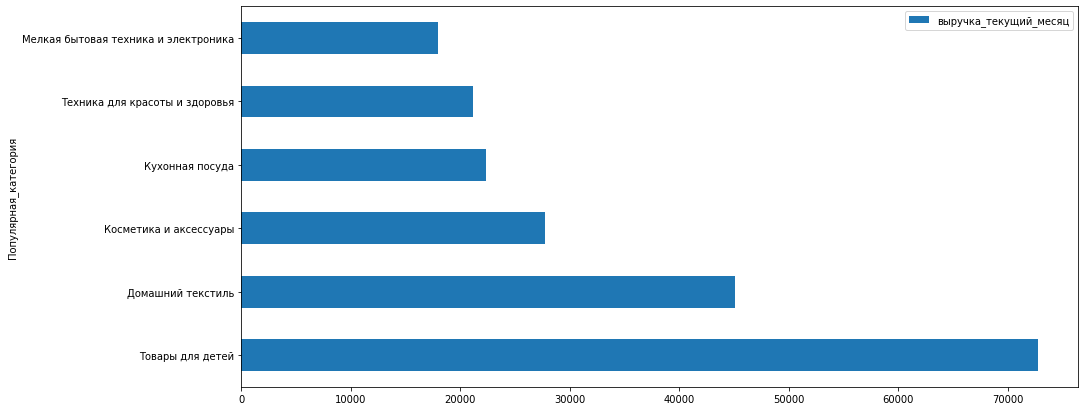

In [128]:
segment1.groupby('Популярная_категория')['выручка_текущий_месяц'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7));

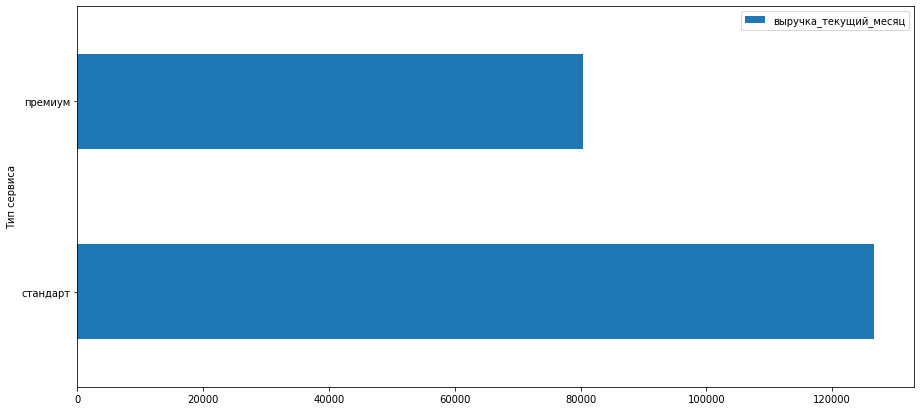

In [129]:
segment1.groupby('Тип сервиса')['выручка_текущий_месяц'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7));

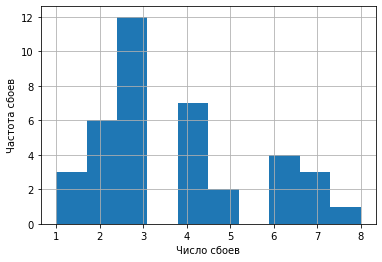

In [130]:
segment1['Ошибка_сервиса'].hist(bins=10);
plt.ylabel('Частота сбоев')
plt.xlabel('Число сбоев')
plt.show()

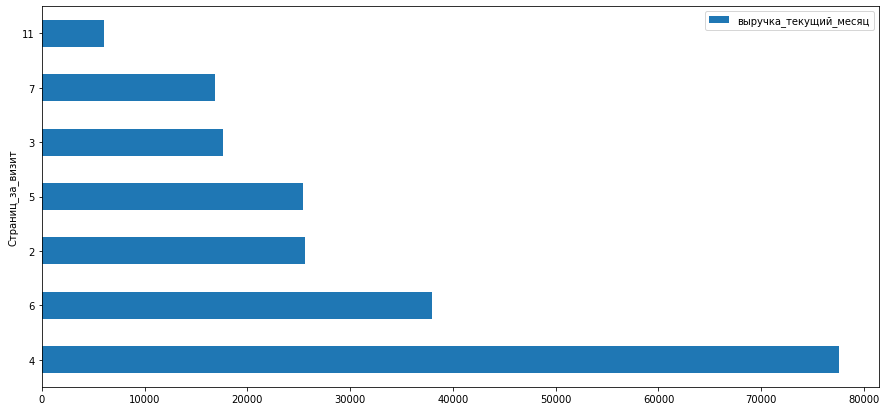

In [131]:
segment1.groupby('Страниц_за_визит')['выручка_текущий_месяц'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7));

Рассмотрели сегмент покупателей который вероятно снизят свою активность, и совершают большой процент покупок по акции.В основном это пользователи пользующиеся подпиской стандарт, просматривают 4 страницы ,сталкиваются с 3 сбоями и покупающие больше всего категорию товары для детей.
Рекомендации которые можно дать:
* Разивать другие категории которые мало покупают, например улучшать ранжирование товаров выносить вверх высококонверсионные товары
* Уменьшить число сбоев,ведь возможно люди которые покупают по акции сталкиваются с ними потому что ждут старта акции и потом сервис начинает падать
* Выручка с просмотром 11 и 7 страниц минимальна, значит пользователь листал листал и так и не нашел нужный товар, нужно более детально изучать что ему помешало, может некорретная выдача отдается
* Привлекать пользователей в подписку , к примеру ввести систему кешбеков или дополнительных скидок, а также ранний старт продаж для премиум подписчиков,бесплатная доставка и т д.

### Шаг 9. Общий вывод

* Загрузили и выполнили предобработку данных, проверили дубликаты, устранили неявные дубликаты в столбцах
* Провели исследовательский анализ данных всех таблиц,общие моменты по каждой
* market_file
 - Посмотрели все категориальные столбцы таблицы market_file:
   - Покупательская активность осталась на прежнем уровне почти в половину раз больше
   - Тип сервиса в три раза больше стандарт чем премиум
   - Разрешают сообщить в три раза больше чем нет
   - Популярная категория лидеры это товары для детей и домашний текстиль, самая низкая популярность у кухонной посуды
 - Посмотрели все численные столбцы таблицы market_file:
   - Маркет_актив_6_мес в среднем 4 в месяц проходят активности маркетинга
   - Длительность большинство клиентов зарегистрированы на сайте чуть больше полутора лет 602 дня
   - Акционные_покупки составляет 0.2, есть выбросы кто то совершает небольшое по частоте(более 100раз) 0.9 возможно люди которые специально отслеживают акции и покупают только в них
   - Средний_просмотр_категорий_за_визит в среднем 3 категории смотрят пользователи за висит
   - Неоплаченные_продукты_штук_квартал за последние три месяца неоплаченные товары примерно 2-3 штуки в большинстве раз
   - Ошибка_сервиса число сбоев в среднем 4
   - Страниц_за_визит примерно 8 страниц в большинстве раз смотрят пользователи
* market_money
 - в периодах есть равное количество данных о выручках
 - убрали выброс в выручку 106862.2 он был там один и очень отличался от всех
 - выручка в среднем 5007 в большинстве раз
* market_time
 - в среднем 13 минут проведено на сайте
* money
 - Значение прибыли в среднем 3.3
* Дополнительно посмотрели на распределение категориальных признаков для обеих групп снизилась и нет покупательская активность
 - По типу сервиса можно сказать что снизилась больше у стандарт, у премиум меньше
 - По категориям сильно снизилась активность в категориях мелкая БТ и электроника и Техника для красоты и здоровья
* Объединили таблицы market_file.csv, market_money.csv, market_time.csv. Данные о выручке и времени на сайте находились в одном столбце для всех периодов. В итоговой таблице сделали отдельный столбец для каждого периода.Проверили что в таблице нет данных о клиентах с выручкой 0 хотя бы в одном периоде
* Провели корелляционный анализ данных,посмотрели матрицы корреляции, мультиколлинеарности не обнаружено.Неплохая корреляция с покупательской активностью у страниц за визит, выручки, минут.
* Выстроили полный пайплайн для обучения модели, использовали ordianal encoder-для ранговых значений и one hot encoder-для бинарных значений.Как бы не казалось что популярная категория должна была бы быть в ordianal encoder, но популярная категория это номинальная переменная, а ранговый столбец у нас тип сервиса так как мы можем сравнить лучше или хуже. Метрику выбрали roc-auc так как у нас несбалансированный класс. По итогу лучшая модель получилась KNeighborsClassifier(n_neighbors=15) ROC-AUC 0.89 
* посмотрели на распределение важности признаков для модели. Наиболее важными модель выделяет сильнее всех признак выручка за предыдущий месяц, неоплаченные продукты, минут текущий месяц, тип сервиса.Наиболее неважными считает минут предыдущий месяц, длительность, выручка препредыдущий месяц
* Рассмотрели сегмент покупателей который вероятно снизят свою активность, и совершают большой процент покупок по акции.В основном это пользователи пользующиеся подпиской стандарт, просматривают 4 страницы ,сталкиваются с 3 сбоями и покупающие больше всего категорию товары для детей.
* Рекомендации которые можно дать:
* Разивать другие категории которые мало покупают, например улучшать ранжирование товаров выносить вверх высококонверсионные товары
* Уменьшить число сбоев,ведь возможно люди которые покупают по акции сталкиваются с ними потому что ждут старта акции и потом сервис начинает падать
* Выручка с просмотром 11 и 7 страниц минимальна, значит пользователь листал листал и так и не нашел нужный товар, нужно более детально изучать что ему помешало, может некорретная выдача отдается
* Привлекать пользователей в подписку , к примеру ввести систему кешбеков или дополнительных скидок, а также ранний старт продаж для премиум подписчиков,бесплатная доставка и т д.